# MethodofLines Tutorial Example Using Staggered Grids 

This is an attempt to run the staggered grid tutorial example at [staggered](https://docs.sciml.ai/MethodOfLines/stable/staggered/). 

In [28]:
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets
using Plots

## Section 1: Modified Tutorial Example Trying to Understand Method Error 

Remove stagggered grid functionality. 

Complains about periodic boundary conditiobns with the message: ┌ Warning: The system contains interface boundaries, which are not compatible with system transformation. The system will not be transformed. Please post an issue if you need this feature.
└ @ MethodOfLines ~/.julia/packages/MethodOfLines/JDu9X/src/system_parsing/pde_system_transformation.jl:43. 

Using Dirichlet boundary conditions instead. 

In [29]:
@parameters t x
@variables ρ(..) ϕ(..)
Dt = Differential(t);
Dx = Differential(x);

a = 5.0; #wave speed
L = 8.0;
dx = 0.125;
dt = dx/a; # CFL condition
tmax = 5e-1;

initialFunction(x) = sin(pi*x);
eq = [Dt(ρ(t,x)) + Dx(ϕ(t,x)) ~ 0,
      Dt(ϕ(t,x)) + a^2 * Dx(ρ(t,x)) ~ 0]
#bcs = [ρ(0,x) ~ initialFunction(x),
#       ϕ(0.0,x) ~ 0.0,
#       ρ(t,L) ~ ρ(t,-L),
#       ϕ(t,-L) ~ ϕ(t,L)];
bcs = [ρ(0,x) ~ initialFunction(x),
       ϕ(0.0,x) ~ 0.0,
       ρ(t,0) ~ 0.0,
       ϕ(t,0) ~ 1.0];

domains = [t in Interval(0.0, tmax),
           x in Interval(0, L)];

In [30]:
@named pdesys = PDESystem(eq, bcs, domains, [t,x], [ρ(t,x), ϕ(t,x)]);

In [31]:
# discretization = MOLFiniteDifference([x=>dx], t, grid_align=MethodOfLines.StaggeredGrid(), edge_aligned_var=ϕ(t,x));
discretization = MOLFiniteDifference([x=>dx], t);

In [32]:
dump(discretization.dxs)

Dict{Num, Float64}
  slots: Memory{UInt8}
    length: Int64 16
    ptr: Ptr{Nothing}(0x00000003157d0a40)
  keys: Memory{Num}
    length: Int64 16
    ptr: Ptr{Nothing}(0x00000003159c8660)
  vals: Memory{Float64}
    length: Int64 16
    ptr: Ptr{Nothing}(0x00000003159c8700)
  ndel: Int64 0
  count: Int64 1
  age: UInt64 0x0000000000000002
  idxfloor: Int64 1
  maxprobe: Int64 0


In [33]:
prob = discretize(pdesys, discretization);

In [34]:
pdesys

PDESystem
Equations: Equation[Differential(t)(ρ(t, x)) + Differential(x)(ϕ(t, x)) ~ 0, 25.0Differential(x)(ρ(t, x)) + Differential(t)(ϕ(t, x)) ~ 0]
Boundary Conditions: Equation[ρ(0, x) ~ sin(πx), ϕ(0.0, x) ~ 0.0, ρ(t, 0) ~ 0.0, ϕ(t, 0) ~ 1.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 0.5), Symbolics.VarDomainPairing(x, 0.0 .. 8.0)]
Dependent Variables: Num[ρ(t, x), ϕ(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [35]:
domains[1]

Symbolics.VarDomainPairing(t, 0.0 .. 0.5)

In [36]:
sol = solve(prob,  dt=dt);

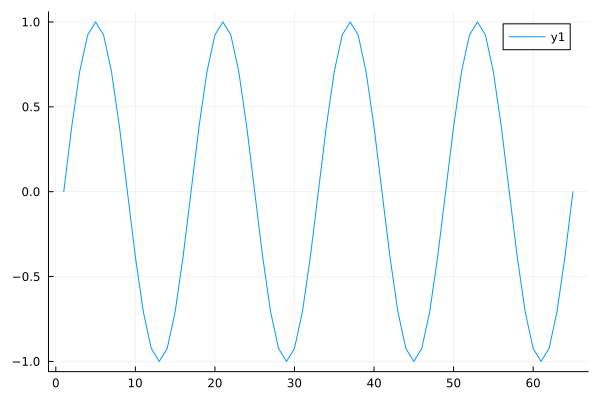

In [37]:
plot(initialFunction.(sol[x]))

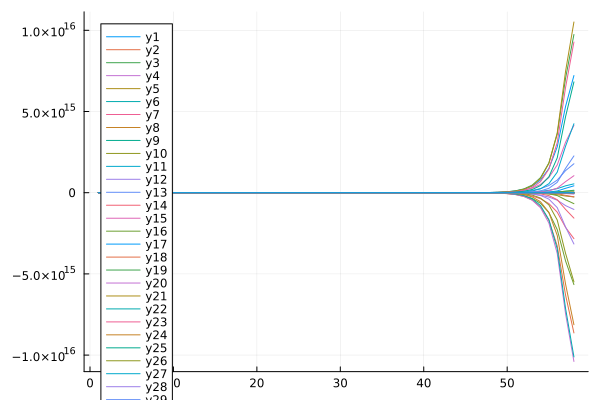

In [38]:
plot(sol.u[ϕ(t,x)])

In [39]:
# surface(sol[t], sol[x], sol[ρ(x,t)],xlabel="t", ylabel="x") 
# surface(sol[t], sol[x], sol[ϕ(x,t)],xlabel="t", ylabel="x")
surface(sol[t], sol[x], sol[u],xlabel="t", ylabel="x")

LoadError: UndefVarError: `u` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

## Section 2: Entire Code that Fails 

The code fails in the call to discretize() with the following method error 

MethodError: no method matching view(::Nothing, ::UnitRange{Int64})
The function `view` exists, but no method is defined for this combination of argument types.

In [41]:
using OrdinaryDiffEq, ModelingToolkit, MethodOfLines, DomainSets
@parameters t x
@variables ρ(..) ϕ(..)
Dt = Differential(t);
Dx = Differential(x);

a = 5.0; #wave speed
L = 8.0;
dx = 0.125;
dt = dx/a; # CFL condition
tmax = 10.0;

initialFunction(x) = exp(-(x-L/2)^2);
eq = [Dt(ρ(t,x)) + Dx(ϕ(t,x)) ~ 0,
      Dt(ϕ(t,x)) + a^2 * Dx(ρ(t,x)) ~ 0]
bcs = [ρ(0,x) ~ initialFunction(x),
       ϕ(0.0,x) ~ 0.0,
       ρ(t,-L) ~ 0., #ρ(t,-L),
       ϕ(t,-L) ~ 0. ]; # ϕ(t,L)];

domains = [t in Interval(0.0, tmax),
           x in Interval(-L, L)];

@named pdesys = PDESystem(eq, bcs, domains, [t,x], [ρ(t,x), ϕ(t,x)]);

discretization = MOLFiniteDifference([x=>dx], t, grid_align=MethodOfLines.StaggeredGrid(), edge_aligned_var=ϕ(t,x));
prob = discretize(pdesys, discretization, analyticd=nothing);

sol = solve(prob, ImplicitEuler(), dt=dt);

In [11]:
methods(discretize)

# 3 methods for generic function "discretize" from SciMLBase:
 [1] discretize(pdesys::PDESystem, discretization::MOLFiniteDifference{G}) where G<:MethodOfLines.StaggeredGrid
     @ ~/.julia/packages/MethodOfLines/JDu9X/src/discretization/staggered_discretize.jl:1
 [2] discretize(pdesys::PDESystem, discretization::MOLFiniteDifference{G}, analytic, kwargs...) where G<:MethodOfLines.StaggeredGrid
     @ ~/.julia/packages/MethodOfLines/JDu9X/src/discretization/staggered_discretize.jl:1
 [3] discretize(pdesys::PDESystem, discretization::PDEBase.AbstractEquationSystemDiscretization; analytic, kwargs...)
     @ ~/.julia/packages/PDEBase/CpWUp/src/discretization_state.jl:54

In [9]:
pdesys

PDESystem
Equations: Equation[Differential(t)(ρ(t, x)) + Differential(x)(ϕ(t, x)) ~ 0, 25.0Differential(x)(ρ(t, x)) + Differential(t)(ϕ(t, x)) ~ 0]
Boundary Conditions: Equation[ρ(0, x) ~ exp(-((-4.0 + x)^2)), ϕ(0.0, x) ~ 0.0, ρ(t, -8.0) ~ 0.0, ϕ(t, -8.0) ~ 0.0]
Domain: Symbolics.VarDomainPairing[Symbolics.VarDomainPairing(t, 0.0 .. 10.0), Symbolics.VarDomainPairing(x, -8.0 .. 8.0)]
Dependent Variables: Num[ρ(t, x), ϕ(t, x)]
Independent Variables: Num[t, x]
Parameters: SciMLBase.NullParameters()
Default Parameter ValuesDict{Any, Any}()

In [1]:
using Pkg; Pkg.status()

Status `~/.julia/environments/v1.12/Project.toml`
  [5b8099bc] DomainSets v0.7.16
  [7073ff75] IJulia v1.31.0
  [94925ecb] MethodOfLines v0.11.9
  [961ee093] ModelingToolkit v10.26.0
  [1dea7af3] OrdinaryDiffEq v6.102.1


In [2]:
using Pkg; Pkg.status(; mode = PKGMODE_MANIFEST)

Status `~/.julia/environments/v1.12/Manifest.toml`
  [47edcb42] ADTypes v1.18.0
  [1520ce14] AbstractTrees v0.4.5
  [7d9f7c33] Accessors v0.1.42
  [79e6a3ab] Adapt v4.4.0
  [66dad0bd] AliasTables v1.1.3
  [ec485272] ArnoldiMethod v0.4.0
  [4fba245c] ArrayInterface v7.21.0
  [4c555306] ArrayLayouts v1.12.0
  [13072b0f] AxisAlgorithms v1.1.0
  [e2ed5e7c] Bijections v0.2.2
  [62783981] BitTwiddlingConvenienceFunctions v0.1.6
  [8e7c35d0] BlockArrays v1.7.2
  [70df07ce] BracketingNonlinearSolve v1.5.0
  [2a0fbf3d] CPUSummary v0.2.7
  [d360d2e6] ChainRulesCore v1.26.0
  [fb6a15b2] CloseOpenIntervals v0.1.13
⌅ [861a8166] Combinatorics v1.0.2
  [a80b9123] CommonMark v0.9.1
  [38540f10] CommonSolve v0.2.4
  [bbf7d656] CommonSubexpressions v0.3.1
  [f70d9fcc] CommonWorldInvalidations v1.0.0
  [34da2185] Compat v4.18.1
  [b152e2b5] CompositeTypes v0.1.4
  [a33af91c] CompositionsBase v0.1.2
  [2569d6c7] ConcreteStructs v0.2.3
  [8f4d0f93] Conda v1.10.2
  [187b0558] ConstructionBase v1.6.0
  [adaf

In [3]:
versioninfo()

Julia Version 1.12.1
Commit ba1e628ee49 (2025-10-17 13:02 UTC)
Build Info:
  Official https://julialang.org release
Platform Info:
  OS: macOS (arm64-apple-darwin24.0.0)
  CPU: 8 × Apple M3
  WORD_SIZE: 64
  LLVM: libLLVM-18.1.7 (ORCJIT, apple-m3)
  GC: Built with stock GC
Threads: 1 default, 1 interactive, 1 GC (on 4 virtual cores)
